<a href="https://colab.research.google.com/github/navidadkhah/Fine-Tuning-LLMs/blob/main/Dataset/Create_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing requirement libraries

In [ ]:
!pip install mutmut
!pip install astor
!pip install libcst

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.7/601.7 kB 11.4 MB/s eta 0:00:00
  Created wheel for junit-xml: filename=junit_xml-1.8-py3-none-any.whl size=6762 sha256=29dbcec4235af916942fc0056ea69449103e86e28babb0904d9b51655f84b284
  Stored in directory: /root/.cache/pip/wheels/9a/ce/b7/f14c277cea6ba09e5e53f89f1ff57a1dd43af9a17d7f065692
Successfully built junit-xml
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 24.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import csv
import json
from collections.abc import Iterator
import ast
import astor
import random
import libcst as cst
import libcst.matchers as m
from decimal import Decimal
import math

# Reading Dataset

In [ ]:
# Reading not completed dataset
path = '/content/drive/MyDrive/Bachelor\'s project/python_codes.csv'
df = pd.read_csv(path)
print(f"Number of Dataframe rows : {df.shape}")
df.head()

Number of Dataframe rows : (23187, 2)


,language,source
0,Python 3,"n, m = map(int, input().split())\na = []\nfor ..."
1,Python 3,"n, m = map(int, input().split())\na = []\nfor ..."
2,Python 3,#In the name of Allah\n\nfrom sys import stdin...
3,Python 3,"s = input()\nl, *v = (int(x) for x in input()...."
4,Python 3,"s = input()\nl, *v = (int(x) for x in input()...."


In [ ]:
# Droping language column
df = df.drop('language', axis=1)
print(df.shape)
df.head()

(23187, 1)


,source
0,"n, m = map(int, input().split())\na = []\nfor ..."
1,"n, m = map(int, input().split())\na = []\nfor ..."
2,#In the name of Allah\n\nfrom sys import stdin...
3,"s = input()\nl, *v = (int(x) for x in input()...."
4,"s = input()\nl, *v = (int(x) for x in input()...."


In [ ]:
# Removing codes cotain comments
def has_comments(code):
    return '#' in code

df = df[~df['source'].apply(has_comments)]
print(df.shape)
df = df.reset_index(drop=True)
df.head()

(17743, 1)


,source
0,"n, m = map(int, input().split())\na = []\nfor ..."
1,"n, m = map(int, input().split())\na = []\nfor ..."
2,"s = input()\nl, *v = (int(x) for x in input()...."
3,"s = input()\nl, *v = (int(x) for x in input()...."
4,"n = int(input())\na = list(map(int, input().sp..."


In [ ]:
# Reducing the number of rows
desired_rows = 6000
selected_list = []
final_df = pd.DataFrame(columns=['source'])
while desired_rows != len(selected_list):
  rand_row = random.randrange(0, df.shape[0])
  if rand_row not in selected_list:
    selected_list.append(rand_row)
    final_df = pd.concat([final_df, pd.DataFrame(df['source'][rand_row:rand_row+1])])
df = final_df.reset_index(drop=True)
print(df.shape)
df.head()

(6000, 1)


,source
0,n = int(input())\nw = [2] * n\nans0 = n\nans =...
1,n = int(input())\ngraph = {}\ninp = input().sp...
2,def f(n):\n count = 1\n while(n>0):\n ...
3,"p,n=input().split()\np=int(p)\nn=int(n)\n\nif ..."
4,import sys\nfrom collections import defaultdic...


In [ ]:
# Deleting extra variables
del selected_list
del rand_row
del final_df
del path
del desired_rows

# Mutanting code
In this section, we use mutation technique code using the CST library. Changing operations in the code and randomly replace with CST operations.
## Why we are using CST?
We are using CST instead of AST because we want to save the format of the structure too and CST does it for us.
<br>
In the output, we expect a mutant code and a line to tell us which line has changed.

In [ ]:
# This cell is used for randomly selecting mutation techniques and applying them to codes

# Initialize the global variable for operations
flag = False
op_list = []

class OperationChanger(cst.CSTTransformer):
    select_operations = [
        cst.Add, cst.Subtract, cst.Multiply, cst.Divide,
        cst.Modulo, cst.Power, cst.FloorDivide,
        cst.LeftShift, cst.RightShift,
        cst.BitOr, cst.BitXor, cst.BitAnd,
        cst.MatrixMultiply
    ]

    operations = [
        cst.Add(), cst.Subtract(), cst.Multiply(), cst.Divide(),
        cst.Modulo(), cst.Power(), cst.FloorDivide(),
        cst.LeftShift(), cst.RightShift(),
        cst.BitOr(), cst.BitXor(), cst.BitAnd(),
        cst.MatrixMultiply()
    ]

    def __init__(self):
        super().__init__()
        self.changed = False  # Flag to track if a change has been made
        global flag
        flag = False  # Ensure global flag is initialized properly

    def leave_BinaryOperation(self, original_node, updated_node):
        global flag  # Declare that we're working with the global 'flag'
        if not self.changed:
            available_op_list = list(set(self.select_operations) - set(op_list))
            if len(available_op_list) == 0:
                available_op_list = self.select_operations
                op_list.clear()

            current_op = random.choice(available_op_list)
            op_list.append(current_op)

            new_op_to_change = random.choice(self.operations)
            if isinstance(updated_node.operator, current_op):
                self.changed = True
                flag = True
                return updated_node.with_changes(
                    operator=new_op_to_change.with_changes(
                        whitespace_before=cst.SimpleWhitespace(value=''),
                        whitespace_after=cst.SimpleWhitespace(value='')
                    )
                )
        return updated_node

# Define OperandCollector and SingleOperandModifier
class OperandCollector(cst.CSTVisitor):
    def __init__(self):
        self.operands = []

    def visit_Name(self, node):
        self.operands.append(node)

class SingleOperandModifier(cst.CSTTransformer):
    def __init__(self, operand_to_modify):
        self.operand_to_modify = operand_to_modify

    def leave_Name(self, original_node, updated_node):
        if original_node == self.operand_to_modify:
            new_name = random.choice(['x', 'y', 'z'])
            return updated_node.with_changes(value=new_name)
        return updated_node

# Define the NumberCollector and NumberModifier
class NumberCollector(cst.CSTVisitor):
    def __init__(self):
        self.numbers = []

    def visit_Integer(self, node):
        self.numbers.append(node)

    def visit_Float(self, node):
        self.numbers.append(node)

class NumberModifier(cst.CSTTransformer):
    def __init__(self, target_node):
        super().__init__()
        self.target_node = target_node

    def leave_Integer(self, original_node, updated_node):
        rand_num = random.randrange(1, 200)
        if original_node == self.target_node:
            return updated_node.with_changes(value=str(rand_num))
        return updated_node

    def leave_Float(self, original_node, updated_node):
        rand_num = random.randrange(1, 200)
        rand_float = random.randrange(1, 10)
        if original_node == self.target_node:
            return updated_node.with_changes(value=str(rand_num) + '.' + str(rand_float))
        return updated_node

# Define the ComparisonCollector and SingleComparisonModifier
class ComparisonCollector(cst.CSTVisitor):
    def __init__(self):
        self.comparisons = []

    def visit_Comparison(self, node):
        self.comparisons.append(node)

class SingleComparisonModifier(cst.CSTTransformer):
    def __init__(self, target_node):
        super().__init__()
        self.target_node = target_node

    def leave_Comparison(self, original_node, updated_node):
        if original_node == self.target_node:
            modified_ops = []
            for operator in updated_node.comparisons:
                if isinstance(operator.operator, cst.LessThan):
                    modified_ops.append(
                        operator.with_changes(
                            operator=cst.GreaterThan().with_changes(
                                whitespace_before=cst.SimpleWhitespace(value=''),
                                whitespace_after=cst.SimpleWhitespace(value='')
                            )
                        )
                    )
                elif isinstance(operator.operator, cst.GreaterThan):
                    modified_ops.append(
                        operator.with_changes(
                            operator=cst.Equal().with_changes(
                                whitespace_before=cst.SimpleWhitespace(value=''),
                                whitespace_after=cst.SimpleWhitespace(value='')
                            )
                        )
                    )
                elif isinstance(operator.operator, cst.Equal):
                    modified_ops.append(
                        operator.with_changes(
                            operator=cst.LessThan().with_changes(
                                whitespace_before=cst.SimpleWhitespace(value=''),
                                whitespace_after=cst.SimpleWhitespace(value='')
                            )
                        )
                    )
                elif isinstance(operator.operator, cst.GreaterThanEqual):
                    modified_ops.append(
                        operator.with_changes(
                            operator=cst.LessThanEqual().with_changes(
                                whitespace_before=cst.SimpleWhitespace(value=''),
                                whitespace_after=cst.SimpleWhitespace(value='')
                            )
                        )
                    )
                elif isinstance(operator.operator, cst.LessThanEqual):
                    modified_ops.append(
                        operator.with_changes(
                            operator=cst.GreaterThanEqual().with_changes(
                                whitespace_before=cst.SimpleWhitespace(value=''),
                                whitespace_after=cst.SimpleWhitespace(value='')
                            )
                        )
                    )
                else:
                    modified_ops.append(operator)
            return updated_node.with_changes(comparisons=modified_ops)
        return updated_node

# Function to randomly select a section and apply the corresponding modification
def randomly_modify_code(tree, code):
    sections = [
        'value',
        'statement',
        'operation',
        'decision'
    ]

    randomList = random.choices(
    sections, weights=(1, 1, 3, 3), k=1)

    selected_section = randomList[0]

    if selected_section == 'operation':
        # print("Selected section: Operation")
        global flag  # Ensure we're working with the global flag
        flag = False  # Reset flag for each call
        modified_tree = tree  # Ensure modified_tree is initialized
        retries = 0
        while not flag and retries < 100:  # Add a retry limit
            transformer = OperationChanger()
            modified_tree = tree.visit(transformer)  # Apply the transformation
            retries += 1  # Increment retry count
        return modified_tree, selected_section

    elif selected_section == 'value':
        # print("Selected section: Value")
        collector = NumberCollector()
        tree.visit(collector)
        if collector.numbers:
            target_node = random.choice(collector.numbers)
            transformer = NumberModifier(target_node)
            modified_tree = tree.visit(transformer)
            return modified_tree, selected_section

    elif selected_section == 'decision':
        # print("Selected section: Decision")
        collector = ComparisonCollector()
        tree.visit(collector)
        if collector.comparisons:
            target_node = random.choice(collector.comparisons)
            transformer = SingleComparisonModifier(target_node)
            modified_tree = tree.visit(transformer)
            return modified_tree, selected_section

    elif selected_section == 'statement':
        # print("Selected section: Statement")
        collector = OperandCollector()
        tree.visit(collector)
        if collector.operands:
            operand_to_modify = random.choice(collector.operands)
            modifier = SingleOperandModifier(operand_to_modify)
            modified_tree = tree.visit(modifier)
            return modified_tree, selected_section

    return tree, None

# Function to modify and print the code
def modify_and_print_code(code):
    # Parse the input code into a CST tree
    tree = cst.parse_module(code)

    # Apply random modifications
    modified_tree, selected_section = randomly_modify_code(tree, code)

    # Convert the modified tree back to a code string
    modified_code = modified_tree.code

    # Print the modified code
    # print("Original Code:")
    # print(code)
    # print("\nModified Code:")
    return modified_code, selected_section

In [ ]:
# This function is used for comparing two codes and shown which line changed
def find_difference(original_code, modified_code):
  # Find witch line has changed
  changed_lines = []
  line = 1;
  num_line = -1
  for original, mutated in zip(original_code.split('\n'), modified_code.split('\n')):
      if original != mutated:
        # print(f"Line {line} has changed")
        num_line = line
        changed_lines.append(mutated)
      line += 1

  # Output changed lines
  if changed_lines:
      # print("\n--- Changed Lines ---")
      for changed_line in changed_lines:
          return changed_line, num_line
  else:
      return "No changes detected.", num_line

In [ ]:
final_dataset = pd.DataFrame(columns=['original_code', 'modified_code', 'changed_line', "number_of_line", 'mutation_type'])
iteration_num = 1

for row in range(df.shape[0]):
    try:
        original_code = df.iloc[row]['source']  # Use iloc for row indexing
    except KeyError:
        print(f"Row {row} missing 'source' field, skipping.")
        continue

    for index in range(5):
        try:
            modified_code, selected_section = modify_and_print_code(original_code)
        except Exception as e:
            print(f"Error in index {index} of row {row}: {e}")  # Catch and log specific errors with row number
            continue

        try:
            changed_line, line_number = find_difference(original_code, modified_code)
            new_data = {
                'original_code': original_code,
                'modified_code': modified_code,
                'changed_line': changed_line,
                'number_of_line': line_number,
                'mutation_type': selected_section
            }
            final_dataset = pd.concat([final_dataset, pd.DataFrame([new_data])], ignore_index=True)
        except Exception as e:
            print(f"Error finding difference at index {index} of row {row}: {e}")
            continue

    # Clean up variables at the end of each row
    try:
        selected_section = None
        original_code = None
        modified_code = None
        changed_line = None
        index = None
        line_number = None
        new_data = None
    except Exception as e:
        print(f"Error in cleanup at row {row}: {e}")  # Catch and log specific errors

    print(f"Iteration {iteration_num}.")
    iteration_num += 1


Streaming output truncated to the last 5000 lines.
Iteration 2626.
Iteration 2627.
Iteration 2628.
Iteration 2629.
Iteration 2630.
Iteration 2631.
Iteration 2632.
Iteration 2633.
Iteration 2634.
Iteration 2635.
Iteration 2636.
Iteration 2637.
Iteration 2638.
Iteration 2639.
Iteration 2640.
Iteration 2641.
Iteration 2642.
Iteration 2643.
Iteration 2644.
Iteration 2645.
Iteration 2646.
Iteration 2647.
Iteration 2648.
Iteration 2649.
Iteration 2650.
Iteration 2651.
Iteration 2652.
Iteration 2653.
Iteration 2654.
Iteration 2655.
Iteration 2656.
Iteration 2657.
Iteration 2658.
Iteration 2659.
Iteration 2660.
Iteration 2661.
Iteration 2662.
Iteration 2663.
Iteration 2664.
Iteration 2665.
Iteration 2666.
Iteration 2667.
Iteration 2668.
Iteration 2669.
Iteration 2670.
Error in index 0 of row 2670: Syntax Error @ 10:11.
parser error: error at 9:10: expected one of !=, %, &, (, *, **, +, ,, -, ., /, //, <, <<, <=, ==, >, >=, >>, @, [, ^, and, if, in, is, not, or, |

    print(ans)
          ^
Er

In [ ]:
# Printing final dataset
print(final_dataset.shape)
final_dataset.head()

(25793, 5)


,original_code,modified_code,changed_line,number_of_line,mutation_type
0,n = int(input())\nw = [2] * n\nans0 = n\nans =...,n = int(input())\nw = [2] * n\nans0 = n\nans =...,"for j in range(y-1, r):",14,statement
1,n = int(input())\nw = [2] * n\nans0 = n\nans =...,n = int(input())\nw = [2] * n\nans0 = n\nans =...,if k<1:,8,decision
2,n = int(input())\nw = [2] * n\nans0 = n\nans =...,n = int(input())\nw = [2] * n\nans0 = n\nans =...,if k<1:,8,decision
3,n = int(input())\nw = [2] * n\nans0 = n\nans =...,n = int(input())\nw = [2] * n\nans0 = n\nans =...,"for j in range(l&1, r):",14,operation
4,n = int(input())\nw = [2] * n\nans0 = n\nans =...,n = int(input())\nw = [2] * n\nans0 = n\nans =...,"l, r, k = list(z(int, input().split()))",7,statement


In [ ]:
# Count rows where 'modified_code' is "None"
modified_code_none_count = len(final_dataset[final_dataset["modified_code"] == None])
print(f"Number of rows where 'modified_code' is 'None': {modified_code_none_count}")

# Count rows where 'changed_line' is "no change line"
changed_line_no_change_count = len(final_dataset[final_dataset["changed_line"] == "No changes detected."])
print(f"Number of rows where 'changed_line' is 'no change line': {changed_line_no_change_count}")

# Count rows where 'number_of_line' is -1
number_of_line_neg1_count = len(final_dataset[final_dataset["number_of_line"] == -1])
print(f"Number of rows where 'number_of_line' is -1: {number_of_line_neg1_count}")


Number of rows where 'modified_code' is 'None': 0
Number of rows where 'changed_line' is 'no change line': 3652
Number of rows where 'number_of_line' is -1: 3652


In [ ]:
final_dataset = final_dataset[
    (final_dataset["number_of_line"] != -1) &
    (final_dataset["changed_line"] != "No changes detected.") &
    (final_dataset["modified_code"] != None)
]
print(final_dataset.shape)
final_dataset.head()

(25793, 5)


,original_code,modified_code,changed_line,number_of_line,mutation_type
0,n = int(input())\nw = [2] * n\nans0 = n\nans =...,n = int(input())\nw = [2] * n\nans0 = n\nans =...,"for j in range(y-1, r):",14,statement
1,n = int(input())\nw = [2] * n\nans0 = n\nans =...,n = int(input())\nw = [2] * n\nans0 = n\nans =...,if k<1:,8,decision
2,n = int(input())\nw = [2] * n\nans0 = n\nans =...,n = int(input())\nw = [2] * n\nans0 = n\nans =...,if k<1:,8,decision
3,n = int(input())\nw = [2] * n\nans0 = n\nans =...,n = int(input())\nw = [2] * n\nans0 = n\nans =...,"for j in range(l&1, r):",14,operation
4,n = int(input())\nw = [2] * n\nans0 = n\nans =...,n = int(input())\nw = [2] * n\nans0 = n\nans =...,"l, r, k = list(z(int, input().split()))",7,statement


In [ ]:
# Count rows where 'modified_code' is "None"
modified_code_none_count = len(final_dataset[final_dataset["modified_code"] == None])
print(f"Number of rows where 'modified_code' is 'None': {modified_code_none_count}")

# Count rows where 'changed_line' is "no change line"
changed_line_no_change_count = len(final_dataset[final_dataset["changed_line"] == "No changes detected."])
print(f"Number of rows where 'changed_line' is 'no change line': {changed_line_no_change_count}")

# Count rows where 'number_of_line' is -1
number_of_line_neg1_count = len(final_dataset[final_dataset["number_of_line"] == -1])
print(f"Number of rows where 'number_of_line' is -1: {number_of_line_neg1_count}")


Number of rows where 'modified_code' is 'None': 0
Number of rows where 'changed_line' is 'no change line': 0
Number of rows where 'number_of_line' is -1: 0


In [ ]:
Path = '/content/drive/MyDrive/Bachelor\'s project/bug_evaluation_dataset.csv'
final_dataset.to_csv(Path, index=False)

In [6]:
import pandas as pd

path = '/content/drive/MyDrive/Bachelor\'s project/bug_evaluation_dataset.csv'
df = pd.read_csv(path)
df.head()

,original_code,modified_code,changed_line,number_of_line,mutation_type
0,n = int(input())\nw = [2] * n\nans0 = n\nans =...,n = int(input())\nw = [2] * n\nans0 = n\nans =...,"for j in range(y-1, r):",14,statement
1,n = int(input())\nw = [2] * n\nans0 = n\nans =...,n = int(input())\nw = [2] * n\nans0 = n\nans =...,if k<1:,8,decision
2,n = int(input())\nw = [2] * n\nans0 = n\nans =...,n = int(input())\nw = [2] * n\nans0 = n\nans =...,if k<1:,8,decision
3,n = int(input())\nw = [2] * n\nans0 = n\nans =...,n = int(input())\nw = [2] * n\nans0 = n\nans =...,"for j in range(l&1, r):",14,operation
4,n = int(input())\nw = [2] * n\nans0 = n\nans =...,n = int(input())\nw = [2] * n\nans0 = n\nans =...,"l, r, k = list(z(int, input().split()))",7,statement


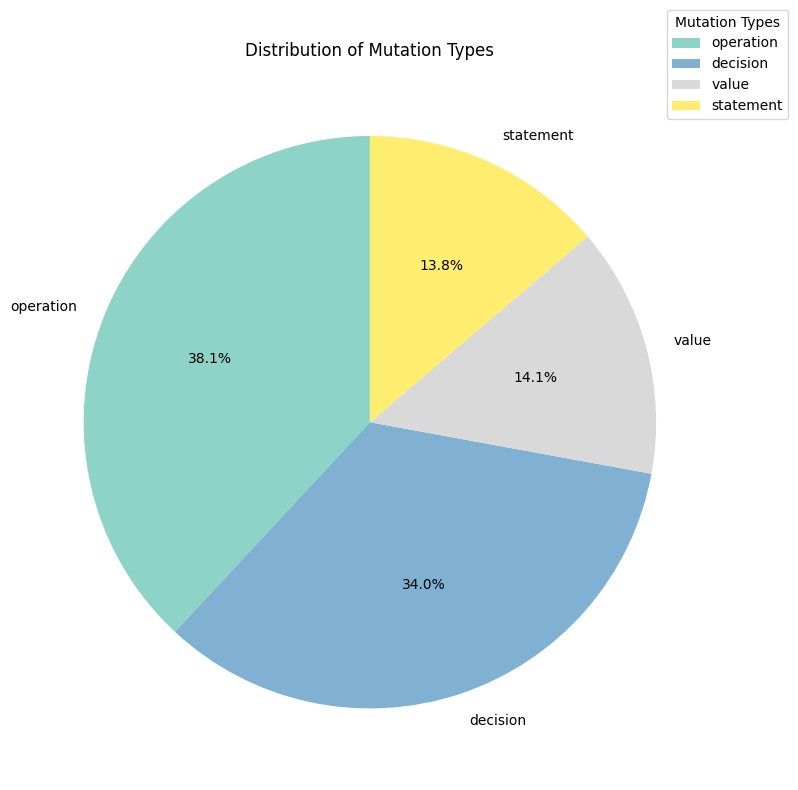

In [17]:
import matplotlib.pyplot as plt

mutation_counts = df['mutation_type'].value_counts()

# Plot the pie chart
plt.figure(figsize=(10, 8))
mutation_counts.plot.pie(autopct='%1.1f%%', startangle=90, cmap="Set3", legend=True)
plt.title('Distribution of Mutation Types')
plt.ylabel('')  # Remove y-axis label for better appearance

# Move the legend upwards
plt.legend(title='Mutation Types', bbox_to_anchor=(1, 1), loc='center', fontsize=10)

plt.tight_layout()
plt.show()